In [1]:
from psaw import PushshiftAPI
import praw
from prawcore import Forbidden
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors
from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc

from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import interp

import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [4]:
client = MongoClient('localhost', 27017)
db = client['cap2']
table = db['first_and_last']

In [5]:
db.list_collection_names()

['submission', 'first_and_last', 'comment']

In [6]:
# count number of documents per collection
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    964
comment       : 234008


## Load the data from mongo

In [7]:
query = {}
fields = { '_id': 0 }
# docs is about 1.3 GB in RAM
docs = list(db['comment'].find( query, fields ))

In [8]:
# comms is about 100 MB in RAM
comms = pd.DataFrame(docs)

In [ ]:
230853 - 6704

In [ ]:
comms.info()

## NLP

In [9]:
orig_stopwords_ = set("a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your,u,s".split(','))

# new stopwords after first run through
# sws_to_add_brf1 = 'thanks,op,tie,deleted,game,crypto,invest,\
# edit,platform,play,giveaway,ok,yeah,blockchain,enter,remove,\
# m,token,awesome,ethereum,exchange,steam,dude'.split(',')

# stopwords_ = set(list(orig_stopwords_) + sws_to_add_brf1)
stopwords_ = orig_stopwords_

punctuation_ = set(string.punctuation + '’' + '“')

def rm_punctuation(a_string):
    table = str.maketrans('', '', ''.join(punctuation_))
    return a_string.translate(table)
        
def tokens_lower(tokens):
    return [word.lower() for word in tokens]

def filter_tokens(tokens):
#     for w in sent: print(w)
#     if w == "’": print("this is ': " + w)
    return [w for w in tokens if not w in stopwords_]

def stem_tokens(ntlk_stem_obj, tokens):
    # visualize what stemming and lemmitization does!
    # str(porter.__class__) = "<class 'nltk.stem.porter.PorterStemmer'>"
#     name = str(ntlk_stem_lemm_obj.__class__).split("'")[1].split('.')[-1]
#     count_ident = 0
#     count_alter = 0
    return [ntlk_stem_obj.stem(tok) for tok in tokens]
#     elif ''
# for tok in tokens:
#         return ntlk_stem_lemm_obj.stem(tok)
#         if tok == stem_lemm_f_l_tok:
#             count_ident += 1
#         else:
#             print(tok, stem_lemm_f_l_tok)
#             count_alter += 1
#     print('{}:\nNumber of unchanged words: {}\nchanged words: {}\n'.format(name, count_ident, count_alter))

def lemm_tokens(ntlk_lemm_obj, tokens):
    return [ntlk_lemm_obj.lemmatize(tok) for tok in tokens]

In [10]:
def nlp_pre_proc_doc(input_string, stemming=False):
    '''
    given document:
        tokenizes the document
        sets tokens to lower case
        filters punctuation and stop words from tokens
        returns porter, snowball, and wordnet stem/lemm tokens
    '''
    no_punct_string = rm_punctuation(input_string)
    tokens = word_tokenize(no_punct_string)
    lo_tokens = tokens_lower(tokens)
    f_lo_tokens = filter_tokens(lo_tokens)
    if stemming:
        s_f_lo_tokens = stem_tokens(porter, f_lo_tokens)
        le_s_f_lo_tokens = lemm_tokens(wordnet, s_f_lo_tokens)
        return ' '.join(le_s_f_lo_tokens)
    else:
        le_f_lo_tokens = lemm_tokens(wordnet, f_lo_tokens)
        return ' '.join(le_f_lo_tokens)

In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [12]:
# this takes a few minutes, and uses about 100 MB of RAM
corpus = [nlp_pre_proc_doc(d) for d in comms['body']]

## Train classifier(s)

In [13]:
# keep a dictionary of trained classifiers for comparison
clfs = {}

### random forest
Spoke with Dan. He suggests using a random forest classifier on the tfidf vectors first to see the individual words that associate with the labels. Cool

need to add the class labels to the comment dataframe, k
do I have the author information from praw-only comments? 
If so, compare with set of troll author names

In [14]:
# assign the label, 'troll?'' to each comment
troll_comment_ids_set = set(comms[~comms['author'].isna()]['id'])
comms['troll?'] = [int(mybool) for mybool in [
                    commid in troll_comment_ids_set for commid in comms['id']
                    ]]
y = comms['troll?']
num_troll_comments = np.sum(y)
num_troll_comments

6704

In [15]:
# is this comment in reply to a troll?
comms['child_of_troll?'] = [int(mybool) for mybool in [
                    pid.split('_')[1] in troll_comment_ids_set for pid in comms['parent_id']
                    ]]
np.sum(comms['child_of_troll?'])

2985

In [16]:
# did a troll reply to this?
troll_parent_ids_set = set(
                            [p.split('_')[1] for p in comms[~comms['author'].isna()]['parent_id']]
                        )
comms['parent_of_troll?'] = [int(myid in troll_parent_ids_set) for myid in comms['id']]

np.sum(comms['parent_of_troll?'])

1824

## First learning step is whether comment is child of troll
do a train test split

In [17]:
X_train_corp, X_test_corp, y_train, y_test = train_test_split(
        corpus, comms['child_of_troll?'], test_size=0.2, random_state=30, shuffle=True)

In [18]:
# still using max features = 5000
n_features = 5000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                                   max_features=n_features,
                                   stop_words='english')

In [19]:
t0 = time.time()
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
print("done in %0.3fs." % (time.time() - t0))

done in 9.262s.


In [20]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_corp)

In [21]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

In [22]:
# fit the model
# at first I did 100 estimators, but 100*25 is only 2500 
#  whereas we have 5000 features in tfidf. Increase to 400
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

In [23]:
brf = BalancedRandomForestClassifier(**model_param, )
brf.fit(X_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [24]:
# include the model for comparisons
clfs['Balanced_RF'] = brf

In [25]:
# measure accuracy
print("\n R^2 score:", brf.score(X_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(X_test)
np.sum(y_predict)


 R^2 score: 0.7136233494295116

 Out of bag score: 0.6844482429490258


13466

In [26]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.02376355265112134
    recall: 0.5545927209705372


#### look at the probabilities with an ROC

In [27]:
def plot_roc_nofit(ax, X_test, y_test, clf, clf_name, **kwargs):
    y_prob = np.zeros((len(y_test),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    # Predict probabilities, not classes
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if len(ax.lines) == 0:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    ax.plot(fpr, tpr, lw=1, label='%s (area = %0.2f)' % (clf_name, roc_auc))
    mean_tpr /= 1
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", )

<ipython-input-27-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


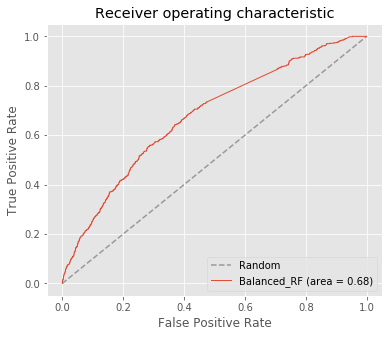

In [28]:
fig, ax = plt.subplots(1, figsize=(6, 5))
for label, clf in clfs.items():
    plot_roc_nofit(ax, X_test, y_test, clf, label)

In [ ]:
def plot_roc(X, y, clf, plot_name, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
#         clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='%s fold %d (area = %0.2f)' % (plot_name, i, roc_auc))
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# see `class_weight` parameter to treat unbalanced classes
# https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30,
                   'class_weight': 'balanced_subsample'
              }

# mini_X_train.shape, mini_y_train.shape

cv_rf = RandomForestClassifier(**model_param)

print("Use the included `plot_roc` function to visualize the roc curve of each model")
plot_roc(X_train, np.array(y_train), cv_rf, 'RandomForest')

## model inspection

#### which features are important?


In [ ]:
#Use sklearn's model to get the feature importances
feature_importances = np.argsort(brf.feature_importances_)
feature_names = np.array(tfidf_vectorizer.get_feature_names())
print("\n: top fifty:", list(feature_names[feature_importances[-1:-51:-1]]))
## top five: ['Day Mins', 'CustServ Calls', 'Day Charge', "Int'l Plan", 'Eve Mins']
## (will vary a little)

In [ ]:
mask = np.array(['gt' in doc for doc in corpus])
np.array(corpus)[mask]

In [ ]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

#### Trolls like to include quotes in their replies, putting the `&gt;` at the beginning of lines in their comments

In [ ]:
mask = np.array(['ayi' in doc for doc in corpus])
np.array(corpus)[mask]

In [ ]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')


#### ayyy lmao ...

In [ ]:
mask = np.array(['tie' in doc for doc in corpus])
np.array(corpus)[mask]

In [ ]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

#### crypto pump 'n dump (enigma and tie)

In [ ]:
mask = np.array(['slave' in doc for doc in corpus])
np.array(corpus)[mask]

In [ ]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

#### america sux, you're all slaves to the police state

In [ ]:
mask = np.array(['obey' in doc for doc in corpus])
np.array(corpus)[mask]

In [ ]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

## new stop words?:

* gt -- part of `&gt;`, the html-encoding calling out quoted text in a comment ...
* ok
* thank
* yeah
* ayi -- part of ayyy lmao

In [29]:
vars(brf)

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'n_estimators': 400,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'min_impurity_split',
  'random_state',
  'ccp_alpha'),
 'bootstrap': True,
 'oob_score': True,
 'n_jobs': -1,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0.0

## train the next classifier on troll?
but now we get to use the information from the previous classification

Specifically, we add two fields to the training data. Specifically, we compute
0) number of replies
1) fraction of replies (reply.parent_id == comment.id) classified as 'child_of_troll'. fillna(mean)


## Is this a bayesian classifier? To fill in for each comment, what's the probability of observing the data under both hypotheses, and if the difference is greater than some threshold call it

we can only do this for comments that have replies. Given 0 replies to a troll, we use the existing classifier. 